## Exploratory Data Analysis

### 1. More feature engineering and selection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

plt.style.use('ggplot')

In [3]:
feature_pickle = '/Users/Xiaoxi/Desktop/BitTiger/Capstone/data/output/play_log_features_and_label.pkl'
df = pd.read_pickle(feature_pickle)
df.head()

,uid,song_popular,device,major_song_type,song_popularity_ratio,total_play_time,play_time_label,avg_play_time,least_pop_count,most_popular_count,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label
0,100077577,0.176471,ip,0,0.176471,3.466667,0-100,12.235294,0.0,10.0,0,0,0,17,0,1
1,100419770,0.113208,ar,1,0.113208,115335.033333,10k+,130567.962264,1.0,15.0,0,0,38,15,0,0
2,100474444,0.579710,ar,0,0.579710,113.666667,100-400,98.840580,0.0,67.0,0,0,0,69,0,1
3,100751531,0.346154,ar,1,0.346154,42.183333,0-100,97.346154,4.0,13.0,0,0,0,0,26,1
4,101231687,0.196989,ar,0,0.196989,3123.683333,1k-7k,235.158093,0.0,557.0,169,83,368,177,0,0


In [168]:
log_pickle = '/Users/Xiaoxi/Desktop/BitTiger/Capstone/data/output/reduced_play_log.pkl'
df_play = pd.read_pickle(log_pickle)
df_play.head()

,index,uid,device,song_type,play_time,song_length,label,date,song_id_new,singer_popularity_rank
0,0,154824972,ar,0,22.0,178,1,20170302,311464,7468
1,1,154412619,ar,0,235.0,235,1,20170302,19974,17
2,2,154830959,ar,0,256.0,256,1,20170302,116,11
3,3,154826319,ar,0,27962.0,0,1,20170302,175551,141
4,4,154470406,ar,0,5.0,247,1,20170302,411,187


In [169]:
# For churn prediction, choose the logs before the cut-off date 20170422
df_play = df_play.loc[df_play.date < '20170422']

In [170]:
df_play.date.unique()

array(['20170302', '20170303', '20170304', '20170305', '20170306',
       '20170307', '20170308', '20170309', '20170330', '20170331',
       '20170339', '20170401', '20170402', '20170403', '20170404',
       '20170405', '20170406', '20170407', '20170408', '20170409',
       '20170410', '20170411', '20170412', '20170413', '20170414',
       '20170415', '20170416', '20170417', '20170418', '20170419',
       '20170420', '20170421', '20170301'], dtype=object)

In [171]:
df_play.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8761997 entries, 0 to 12787363
Data columns (total 10 columns):
index                     int64
uid                       object
device                    object
song_type                 object
play_time                 float64
song_length               object
label                     object
date                      object
song_id_new               int64
singer_popularity_rank    int64
dtypes: float64(1), int64(3), object(6)
memory usage: 735.3+ MB


In [8]:
df_temp = df_play[['date','label']].groupby(['date']).count().rename(columns={'label':'log_count'})

In [9]:
df_temp.head()

,log_count
date,
20170301,320529
20170302,243506
20170303,168531
20170304,146172
20170305,141878


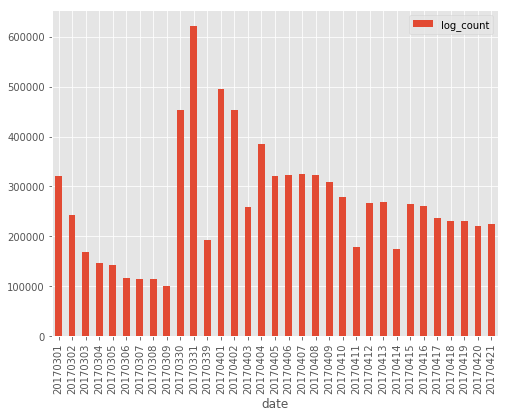

In [10]:
# Plot play_log_count vs date
plt.rcParams["figure.figsize"] = (8,6)
ax0 = df_temp.plot.bar()
plt.show()

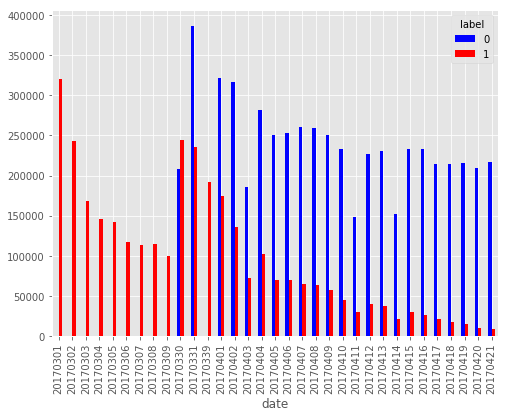

In [11]:
# Compare number of churns for different dates
plt.rcParams["figure.figsize"] = (8,6)
ax = df_play.groupby(['date','label']).size().unstack().fillna(0).plot.bar(color = ['b','r'])
plt.show()

It is clear that churn rate reduces as date approaches the cut-off date 2017/04/22, so last active date shoud be a very important feature. 

#### 1.1 Completion ratio: play_time / song_length 

In [187]:
df_play['song_length'] = pd.to_numeric(df_play.song_length, errors='coerce')

In [188]:
# There are missing song_length as '', which were not detected in the previous data cleansing step.
df_play.isnull().sum(axis = 0)

index                        0
uid                          0
device                       0
song_type                    0
play_time                 7236
song_length               3592
label                        0
date                         0
song_id_new                  0
singer_popularity_rank       0
dtype: int64

In [189]:
df_play.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8761997 entries, 0 to 12787363
Data columns (total 10 columns):
index                     int64
uid                       object
device                    object
song_type                 object
play_time                 float64
song_length               float64
label                     object
date                      object
song_id_new               int64
singer_popularity_rank    int64
dtypes: float64(2), int64(3), object(5)
memory usage: 735.3+ MB


In [190]:
# Where there are missing song_length or play_time, set value to 0. 
df_play.loc[df_play.song_length.isnull(),'song_length'] = 0
df_play.loc[df_play.play_time.isnull(),'play_time'] = 0

In [191]:
df_play.isnull().sum(axis = 0)

index                     0
uid                       0
device                    0
song_type                 0
play_time                 0
song_length               0
label                     0
date                      0
song_id_new               0
singer_popularity_rank    0
dtype: int64

In [196]:
# There are negative song_length logs, which should be taken are of.
df_play.loc[df_play.song_length < 0].groupby('song_length').count()

,index,uid,device,song_type,play_time,label,date,song_id_new,singer_popularity_rank
song_length,,,,,,,,,
-2.147484e+09,12,12,12,12,12,12,12,12,12
-1.000000e+00,2026,2026,2026,2026,2026,2026,2026,2026,2026


In [198]:
# Looks like -1 is a common value as negative song_length, replace -1 with 1 and replace -2.147484e+09 with 1
df_play.loc[df_play.song_length < 0,'song_length'] = 1

In [199]:
df_play.loc[df_play.song_length < 0]

,index,uid,device,song_type,play_time,song_length,label,date,song_id_new,singer_popularity_rank


In [197]:
df_play.loc[df_play.play_time < 0].groupby('play_time').count()

,index,uid,device,song_type,song_length,label,date,song_id_new,singer_popularity_rank
play_time,,,,,,,,,
-2.147484e+09,12,12,12,12,12,12,12,12,12
-7.745105e-02,1,1,1,1,1,1,1,1,1
-2.523564e-02,1,1,1,1,1,1,1,1,1
-2.321226e-02,1,1,1,1,1,1,1,1,1
-2.277194e-02,1,1,1,1,1,1,1,1,1
-1.655847e-02,1,1,1,1,1,1,1,1,1
-1.397686e-02,2,2,2,2,2,2,2,2,2
-1.361866e-02,1,1,1,1,1,1,1,1,1
-1.024768e-02,1,1,1,1,1,1,1,1,1


In [201]:
# looks like -2.147484e+09 is also a common negative value for negative play_time. Replace with 1.
# All other play_time's absolute value seems normal. Replace with their abs.
df_play.loc[df_play.play_time == -2.147484e+09,'play_time'] = 1


In [202]:
df_play.loc[df_play.play_time < 0,'play_time'] = df_play.loc[df_play.play_time < 0,'play_time'].apply(lambda x: abs(x))

In [203]:
df_play.loc[df_play.play_time < 0].groupby('play_time').count()

,index,uid,device,song_type,song_length,label,date,song_id_new,singer_popularity_rank
play_time,,,,,,,,,


### Need to modify the total_play_time and play_time_label in df.

In [265]:
df.total_play_time = list(df_play.groupby('uid')['play_time'].sum()/60)# change time unit to minutes
sum(df.total_play_time>100000)

645

In [266]:
bins = [-1,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,float('inf')]
bin_names = ['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','800-900','900-1k',\
             '1k-2k','2k-3k','3k-4k','4k-5k','5k-6k','6k-7k','7k-8k','8k-9k','9k-10k','10k+']
play_time_label = pd.cut(df.total_play_time,bins, labels = bin_names)
play_time_label.value_counts()

0-100      41715
100-200     9133
200-300     4652
300-400     3162
1k-2k       3124
400-500     2276
500-600     1732
10k+        1653
600-700     1398
700-800     1159
2k-3k        939
800-900      911
900-1k       691
3k-4k        386
4k-5k        201
5k-6k        134
6k-7k         87
7k-8k         73
9k-10k        34
8k-9k         34
Name: total_play_time, dtype: int64

In [267]:
df.groupby(play_time_label).mean()['label']


total_play_time
0-100      0.807527
100-200    0.632541
200-300    0.546217
300-400    0.498102
400-500    0.481107
500-600    0.411663
600-700    0.389127
700-800    0.339948
800-900    0.346872
900-1k     0.293777
1k-2k      0.271127
2k-3k      0.237487
3k-4k      0.272021
4k-5k      0.333333
5k-6k      0.343284
6k-7k      0.379310
7k-8k      0.383562
8k-9k      0.617647
9k-10k     0.617647
10k+       0.814277
Name: label, dtype: float64

In [268]:
df['play_time_label'] = play_time_label
df.head()

,uid,song_popular,device,major_song_type,song_popularity_ratio,total_play_time,play_time_label,avg_play_time,least_pop_count,most_popular_count,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label,avg_complete_ratio,days_since_last_play,active_days
0,100077577,0.176471,ip,0,0.176471,3.466667,0-100,12.235294,0.0,10.0,0,0,0,17,0,1,0.751198,22,1
1,100419770,0.113208,ar,1,0.113208,115335.033333,10k+,130567.962264,1.0,15.0,0,0,38,15,0,0,1.000000,13,7
2,100474444,0.579710,ar,0,0.579710,113.666667,100-200,98.840580,0.0,67.0,0,0,0,69,0,1,0.414544,21,1
3,100751531,0.346154,ar,1,0.346154,42.183333,0-100,97.346154,4.0,13.0,0,0,0,0,26,1,0.451495,48,3
4,101231687,0.196989,ar,0,0.196989,2962.783333,2k-3k,235.158093,0.0,557.0,169,83,368,177,0,0,0.886859,0,14


In [213]:
# completion ratio of each song playing activity
df_play['play_ratio'] = df_play.play_time / df_play.song_length
df_play['play_ratio'] = df_play['play_ratio'].apply(abs)
df_play.head()

,index,uid,device,song_type,play_time,song_length,label,date,song_id_new,singer_popularity_rank,play_ratio
0,0,154824972,ar,0,22.0,178.0,1,20170302,311464,7468,0.123596
1,1,154412619,ar,0,235.0,235.0,1,20170302,19974,17,1.000000
2,2,154830959,ar,0,256.0,256.0,1,20170302,116,11,1.000000
3,3,154826319,ar,0,27962.0,0.0,1,20170302,175551,141,inf
4,4,154470406,ar,0,5.0,247.0,1,20170302,411,187,0.020243


In [214]:
# For the logs with 0 song length, set play_ratio to 1
df_play.loc[(df_play.song_length == 0) |(df_play.song_length == 0.0), 'play_ratio'] = 1
df_play.head()

,index,uid,device,song_type,play_time,song_length,label,date,song_id_new,singer_popularity_rank,play_ratio
0,0,154824972,ar,0,22.0,178.0,1,20170302,311464,7468,0.123596
1,1,154412619,ar,0,235.0,235.0,1,20170302,19974,17,1.000000
2,2,154830959,ar,0,256.0,256.0,1,20170302,116,11,1.000000
3,3,154826319,ar,0,27962.0,0.0,1,20170302,175551,141,1.000000
4,4,154470406,ar,0,5.0,247.0,1,20170302,411,187,0.020243


In [215]:
df_play.play_ratio.describe()

count    8.761997e+06
mean     3.033858e+03
std      2.515406e+06
min      0.000000e+00
25%      4.850746e-02
50%      9.894366e-01
75%      1.000000e+00
max      2.147484e+09
Name: play_ratio, dtype: float64

In [217]:
df_play.loc[df_play.play_ratio > 1000000]

,index,uid,device,song_type,play_time,song_length,label,date,song_id_new,singer_popularity_rank,play_ratio
144036,186619,154600012,ar,1,7.276967e+10,254.0,1,20170302,90652,137,2.864948e+08
1383970,1966626,168822677,ar,1,1.324135e+06,1.0,1,20170330,35118,18,1.324135e+06
1638193,2252009,167932172,ar,0,2.439317e+06,1.0,0,20170331,439747,50714,2.439317e+06
1900039,2583481,168395543,ar,0,3.390903e+06,1.0,1,20170331,577713,253,3.390903e+06
2743048,3638417,168879620,ar,1,6.064927e+06,1.0,0,20170401,12611,795,6.064927e+06
3710804,5035724,167646347,ar,1,4.225183e+06,1.0,1,20170404,70970,335,4.225183e+06
3762273,5115295,168422725,ar,1,2.023187e+06,1.0,0,20170404,163485,1521,2.023187e+06
4090268,5571991,167826027,ip,0,2.147484e+09,1.0,0,20170405,293,276,2.147484e+09
4173792,5685800,168214025,ip,0,2.147484e+09,1.0,0,20170405,19722,846,2.147484e+09
4411894,5998563,167826027,ip,0,2.147484e+09,1.0,0,20170406,293,276,2.147484e+09


In [218]:
# It does not make much sense to have play_ratio >1
df_play.loc[df_play.play_ratio > 1,'play_ratio'] = 1

In [219]:
# For each user:
df['avg_complete_ratio'] = list(df_play.groupby('uid').mean()['play_ratio'])
df.head()

,uid,song_popular,device,major_song_type,song_popularity_ratio,total_play_time,play_time_label,avg_play_time,least_pop_count,most_popular_count,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label,avg_complete_ratio,days_since_last_play,active_days
0,100077577,0.176471,ip,0,0.176471,3.466667,0-100,12.235294,0.0,10.0,0,0,0,17,0,1,0.751198,22,1
1,100419770,0.113208,ar,1,0.113208,115335.033333,10k+,130567.962264,1.0,15.0,0,0,38,15,0,0,1.000000,13,7
2,100474444,0.579710,ar,0,0.579710,113.666667,100-400,98.840580,0.0,67.0,0,0,0,69,0,1,0.414544,21,1
3,100751531,0.346154,ar,1,0.346154,42.183333,0-100,97.346154,4.0,13.0,0,0,0,0,26,1,0.451495,48,3
4,101231687,0.196989,ar,0,0.196989,3123.683333,1k-7k,235.158093,0.0,557.0,169,83,368,177,0,0,0.886859,0,14


In [220]:
df['avg_complete_ratio'].describe()


count    73494.000000
mean         0.605195
std          0.256399
min          0.000000
25%          0.414804
50%          0.628145
75%          0.818607
max          1.000000
Name: avg_complete_ratio, dtype: float64

In [221]:
df.loc[df.avg_complete_ratio<0.1].label.mean(), df.loc[df.avg_complete_ratio>=0.1].label.mean()

(0.8804898648648649, 0.6677726850940584)

In [222]:
df.loc[df.avg_complete_ratio<=0.1].shape

(2369, 19)

#### 1.2 Days since last active

This is actually the first feature that needs to be figure out for this churn model.

The median or a certain quantile should be used for defining churns.

In [223]:
df_daily_play = df_play.groupby(['uid','date']).size().unstack().notnull()
df_daily_play.head()

date,20170301,20170302,20170303,20170304,20170305,20170306,20170307,20170308,20170309,20170330,...,20170412,20170413,20170414,20170415,20170416,20170417,20170418,20170419,20170420,20170421
uid,,,,,,,,,,,,,,,,,,,,,
100077577,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100419770,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100474444,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100751531,True,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
101231687,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,True,True,False,True


In [224]:
days = len(df_daily_play.columns)

In [225]:
days

33

In [228]:
day_list = range(1, days+1)

In [229]:
active_day = df_daily_play.iloc[3,:]*day_list
active_day, active_day.index

(date
 20170301    1
 20170302    0
 20170303    3
 20170304    4
 20170305    0
 20170306    0
 20170307    0
 20170308    0
 20170309    0
 20170330    0
 20170331    0
 20170339    0
 20170401    0
 20170402    0
 20170403    0
 20170404    0
 20170405    0
 20170406    0
 20170407    0
 20170408    0
 20170409    0
 20170410    0
 20170411    0
 20170412    0
 20170413    0
 20170414    0
 20170415    0
 20170416    0
 20170417    0
 20170418    0
 20170419    0
 20170420    0
 20170421    0
 Name: 100751531 , dtype: int64,
 Index([u'20170301', u'20170302', u'20170303', u'20170304', u'20170305',
        u'20170306', u'20170307', u'20170308', u'20170309', u'20170330',
        u'20170331', u'20170339', u'20170401', u'20170402', u'20170403',
        u'20170404', u'20170405', u'20170406', u'20170407', u'20170408',
        u'20170409', u'20170410', u'20170411', u'20170412', u'20170413',
        u'20170414', u'20170415', u'20170416', u'20170417', u'20170418',
        u'20170419', u'20170

In [230]:
active_day.index[max(active_day)]

'20170305'

In [231]:
days - max(active_day)

29

In [232]:
df_daily_play.shape

(73494, 33)

In [233]:
df_daily_play['days_since_last_play'] = \
    [days - max(df_daily_play.iloc[i,:]*day_list) for i in xrange(df_daily_play.shape[0])]
df_daily_play.head()


date,20170301,20170302,20170303,20170304,20170305,20170306,20170307,20170308,20170309,20170330,...,20170413,20170414,20170415,20170416,20170417,20170418,20170419,20170420,20170421,days_since_last_play
uid,,,,,,,,,,,,,,,,,,,,,
100077577,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,22
100419770,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,13
100474444,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,21
100751531,True,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,29
101231687,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,True,True,False,True,0


In [234]:
df_daily_play.shape

(73494, 34)

In [235]:
df_daily_play.loc[df_daily_play['days_since_last_play'] >=24, ['days_since_last_play']] = \
df_daily_play.loc[df_daily_play['days_since_last_play'] >=24, ['days_since_last_play']].apply(lambda x: x + 19)

In [236]:
df_daily_play['days_since_last_play'].value_counts()

0     8946
23    6987
21    6446
51    4537
43    4107
1     3560
22    3354
2     2593
17    2258
20    2256
19    2033
3     1979
44    1828
5     1801
4     1773
50    1577
6     1475
8     1219
45    1203
12    1190
15    1188
14    1150
49    1134
13    1117
47    1100
11    1087
9     1065
48    1039
7      989
46     963
18     938
10     602
Name: days_since_last_play, dtype: int64

In [237]:
df['days_since_last_play'] = list(df_daily_play['days_since_last_play'])
df.head()

,uid,song_popular,device,major_song_type,song_popularity_ratio,total_play_time,play_time_label,avg_play_time,least_pop_count,most_popular_count,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label,avg_complete_ratio,days_since_last_play,active_days
0,100077577,0.176471,ip,0,0.176471,3.466667,0-100,12.235294,0.0,10.0,0,0,0,17,0,1,0.751198,22,1
1,100419770,0.113208,ar,1,0.113208,115335.033333,10k+,130567.962264,1.0,15.0,0,0,38,15,0,0,1.000000,13,7
2,100474444,0.579710,ar,0,0.579710,113.666667,100-400,98.840580,0.0,67.0,0,0,0,69,0,1,0.414544,21,1
3,100751531,0.346154,ar,1,0.346154,42.183333,0-100,97.346154,4.0,13.0,0,0,0,0,26,1,0.451495,48,3
4,101231687,0.196989,ar,0,0.196989,3123.683333,1k-7k,235.158093,0.0,557.0,169,83,368,177,0,0,0.886859,0,14


In [238]:
df.days_since_last_play.describe()


count    73494.000000
mean        20.114581
std         17.036758
min          0.000000
25%          4.000000
50%         19.000000
75%         23.000000
max         51.000000
Name: days_since_last_play, dtype: float64

In [239]:
# average churn rate vs. median of the days_since_last_play

df.loc[df.days_since_last_play > 3].label.mean(),df.loc[df.days_since_last_play <= 3].label.mean()

(0.8409316505955757, 0.12524885818011477)

#### 1.3 active_days: days when a user had at least one activity

This might take off the influence of the outliers, who play huge amount of songs each day


In [240]:
df_daily_play.head()

date,20170301,20170302,20170303,20170304,20170305,20170306,20170307,20170308,20170309,20170330,...,20170413,20170414,20170415,20170416,20170417,20170418,20170419,20170420,20170421,days_since_last_play
uid,,,,,,,,,,,,,,,,,,,,,
100077577,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,22
100419770,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,13
100474444,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,21
100751531,True,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,48
101231687,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,True,True,False,True,0


In [241]:
# if a user had any activity on each day
df_daily_active = df_play.groupby(['uid','date']).size().unstack().notnull()
df_daily_active.head()

date,20170301,20170302,20170303,20170304,20170305,20170306,20170307,20170308,20170309,20170330,...,20170412,20170413,20170414,20170415,20170416,20170417,20170418,20170419,20170420,20170421
uid,,,,,,,,,,,,,,,,,,,,,
100077577,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100419770,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100474444,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100751531,True,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
101231687,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,True,True,False,True


In [242]:
df['active_days']= list(df_daily_active.sum(axis=1))
df.head()

,uid,song_popular,device,major_song_type,song_popularity_ratio,total_play_time,play_time_label,avg_play_time,least_pop_count,most_popular_count,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label,avg_complete_ratio,days_since_last_play,active_days
0,100077577,0.176471,ip,0,0.176471,3.466667,0-100,12.235294,0.0,10.0,0,0,0,17,0,1,0.751198,22,1
1,100419770,0.113208,ar,1,0.113208,115335.033333,10k+,130567.962264,1.0,15.0,0,0,38,15,0,0,1.000000,13,7
2,100474444,0.579710,ar,0,0.579710,113.666667,100-400,98.840580,0.0,67.0,0,0,0,69,0,1,0.414544,21,1
3,100751531,0.346154,ar,1,0.346154,42.183333,0-100,97.346154,4.0,13.0,0,0,0,0,26,1,0.451495,48,3
4,101231687,0.196989,ar,0,0.196989,3123.683333,1k-7k,235.158093,0.0,557.0,169,83,368,177,0,0,0.886859,0,14


In [243]:
df_daily_active.iloc[0].sum()

1

In [244]:
df.groupby(['active_days','label']).size().unstack()

label,0,1
active_days,,
1,1587,21805
2,2063,8621
3,2197,5365
4,1922,3644
5,1718,2676
6,1580,1714
7,1533,1564
8,1343,1366
9,1240,1266


In [245]:
df.loc[df.active_days > 8].label.mean(),df.loc[df.active_days <= 8].label.mean()

(0.22085026570803376, 0.7702889716300372)

There is clear dependence of churn-rate on active_days

#### Feature engineering is done

In [246]:
df.shape

(73494, 19)

In [247]:
df.iloc[0,:].apply(type).value_counts()

<type 'numpy.int64'>      8
<type 'numpy.float64'>    7
<type 'str'>              4
Name: 0, dtype: int64

In [248]:
# Save new dataframe with all features
filename_pickle = '/Users/Xiaoxi/Desktop/BitTiger/Capstone/data/output/play_full_features_and_label.pkl'
df.to_pickle(filename_pickle)

### 2. EDA
For categorical features, or numerical features with discrete values: Bar plot <br>
For numeric features with continues values: histogram


2.1 device vs. churn

In [249]:
df_device = df.groupby(['device','label']).size().unstack()
df_device

label,0,1
device,,
ar,19735,43740
ip,4178,5841


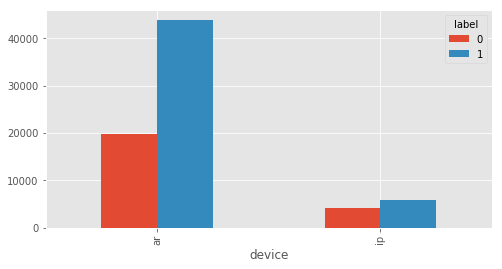

In [250]:
ax = df_device.plot.bar()
plt.show()

#### Users using iphone is less likely to churn compared to using android

2.2 Song_type vs. Churn


In [251]:
df_song_type = df.groupby(['major_song_type','label']).size().unstack()
df_song_type

label,0,1
major_song_type,,
0,22104.0,45321.0
1,1657.0,3828.0
2,152.0,430.0
3,NaN,2.0


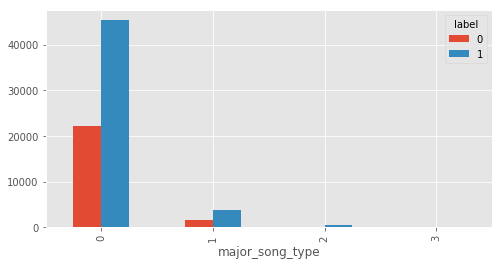

In [252]:
ax = df_song_type.plot.bar()
plt.show()

#### Not very clear dependence on the song_type

2.3 Active_days vs churn

In [253]:
df_active_days = df.groupby(['active_days','label']).size().unstack().fillna(0)
df_active_days

label,0,1
active_days,,
1,1587,21805
2,2063,8621
3,2197,5365
4,1922,3644
5,1718,2676
6,1580,1714
7,1533,1564
8,1343,1366
9,1240,1266


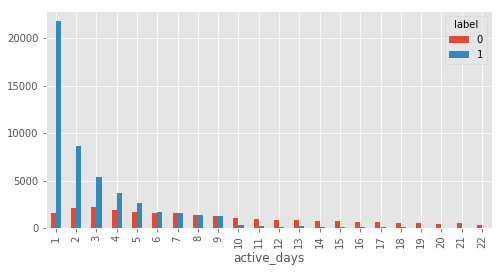

In [254]:
ax = df_active_days.plot.bar()
plt.rcParams["figure.figsize"] = (8,4)
plt.show()

#### Users with less than 3 activities have a very large probabilty to churn. 

2.4 days_since_last_play vs churn


In [255]:
df_days_since_last_play = df.groupby(['days_since_last_play','label']).size().unstack()
df_days_since_last_play

label,0,1
days_since_last_play,,
0,8393.0,553.0
1,3075.0,485.0
2,2021.0,572.0
3,1450.0,529.0
4,1065.0,708.0
5,1191.0,610.0
6,917.0,558.0
7,512.0,477.0
8,560.0,659.0


2.5 total_play_time


In [269]:
df.loc[df['total_play_time'] <0]

,uid,song_popular,device,major_song_type,song_popularity_ratio,total_play_time,play_time_label,avg_play_time,least_pop_count,most_popular_count,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label,avg_complete_ratio,days_since_last_play,active_days


In [270]:
df.total_play_time.describe()


count    7.349400e+04
mean     2.764768e+04
std      4.647694e+06
min      0.000000e+00
25%      1.923333e+01
50%      7.040833e+01
75%      2.900833e+02
max      1.215109e+09
Name: total_play_time, dtype: float64

In [272]:
df.groupby('label').mean()


,song_popular,song_popularity_ratio,total_play_time,avg_play_time,least_pop_count,most_popular_count,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,avg_complete_ratio,days_since_last_play,active_days
label,,,,,,,,,,,,,,
0,0.306240,0.306240,23080.488997,2786.217203,4.624807,150.660687,64.170326,61.706436,75.601807,38.340317,0.000000,0.617749,4.539456,8.398528
1,0.361651,0.361651,29850.438421,10651.206632,1.797443,41.092092,1.999758,5.352252,11.695952,26.058087,20.584821,0.599140,27.626490,2.977633


In [273]:
df_play_time = df.loc[:,['total_play_time','label']]


In [274]:
df_play_time.head()

,total_play_time,label
0,3.466667,1
1,115335.033333,0
2,113.666667,1
3,42.183333,1
4,2962.783333,0


In [319]:
# Reduce number of total_play_time bins. 
bins_play_time = [0,100,400,700,1000,7000,10000,float('inf')]

In [320]:
df_play_time['bins'] = list(pd.cut(df.total_play_time, bins=bins_play_time, 
       right=False, labels=None, retbins=False, precision=1, include_lowest=True))
df_play_time.bins = df_play_time.bins.fillna('[2000,inf)')
df_play_time.head()

,total_play_time,label,bins
0,3.466667,1,"[0.0, 100.0)"
1,115335.033333,0,"[10000.0, inf)"
2,113.666667,1,"[100.0, 400.0)"
3,42.183333,1,"[0.0, 100.0)"
4,2962.783333,0,"[1000.0, 7000.0)"


In [321]:
df_play_time_bins = df_play_time.groupby(['bins','label']).size().unstack().fillna(0)
df_play_time_bins

label,0,1
bins,,
"[0.0, 100.0)",8027,33685
"[100.0, 400.0)",7056,9894
"[400.0, 700.0)",3054,2351
"[700.0, 1000.0)",1848,914
"[1000.0, 7000.0)",3550,1321
"[7000.0, 10000.0)",71,70
"[10000.0, inf)",307,1346


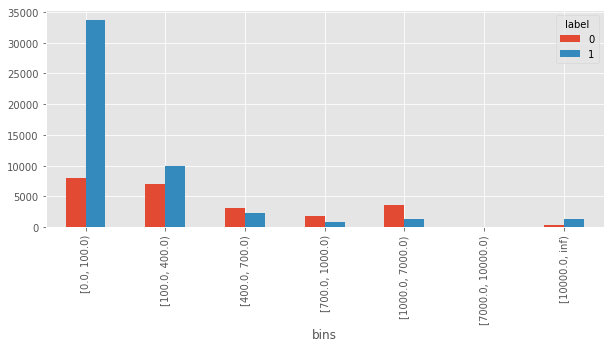

In [322]:
ax = df_play_time_bins.plot.bar()
plt.rcParams["figure.figsize"] = (6,4)
plt.show()

In [323]:
df['play_time_bins'] = df_play_time.bins
df.head()

,uid,song_popular,device,major_song_type,song_popularity_ratio,total_play_time,play_time_label,avg_play_time,least_pop_count,most_popular_count,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label,avg_complete_ratio,days_since_last_play,active_days,play_time_bins
0,100077577,0.176471,ip,0,0.176471,3.466667,0-100,12.235294,0.0,10.0,0,0,0,17,0,1,0.751198,22,1,"[0.0, 100.0)"
1,100419770,0.113208,ar,1,0.113208,115335.033333,10k+,130567.962264,1.0,15.0,0,0,38,15,0,0,1.000000,13,7,"[10000.0, inf)"
2,100474444,0.579710,ar,0,0.579710,113.666667,100-200,98.840580,0.0,67.0,0,0,0,69,0,1,0.414544,21,1,"[100.0, 400.0)"
3,100751531,0.346154,ar,1,0.346154,42.183333,0-100,97.346154,4.0,13.0,0,0,0,0,26,1,0.451495,48,3,"[0.0, 100.0)"
4,101231687,0.196989,ar,0,0.196989,2962.783333,2k-3k,235.158093,0.0,557.0,169,83,368,177,0,0,0.886859,0,14,"[1000.0, 7000.0)"


In [324]:
df = df.drop('play_time_label',axis = 1)
df.head()

,uid,song_popular,device,major_song_type,song_popularity_ratio,total_play_time,avg_play_time,least_pop_count,most_popular_count,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label,avg_complete_ratio,days_since_last_play,active_days,play_time_bins
0,100077577,0.176471,ip,0,0.176471,3.466667,12.235294,0.0,10.0,0,0,0,17,0,1,0.751198,22,1,"[0.0, 100.0)"
1,100419770,0.113208,ar,1,0.113208,115335.033333,130567.962264,1.0,15.0,0,0,38,15,0,0,1.000000,13,7,"[10000.0, inf)"
2,100474444,0.579710,ar,0,0.579710,113.666667,98.840580,0.0,67.0,0,0,0,69,0,1,0.414544,21,1,"[100.0, 400.0)"
3,100751531,0.346154,ar,1,0.346154,42.183333,97.346154,4.0,13.0,0,0,0,0,26,1,0.451495,48,3,"[0.0, 100.0)"
4,101231687,0.196989,ar,0,0.196989,2962.783333,235.158093,0.0,557.0,169,83,368,177,0,0,0.886859,0,14,"[1000.0, 7000.0)"


Churn rate is higher in when total play time < 200 mins

#### 2.6 Churn rate and counts of logs in different time window

In [280]:
df.columns


Index([u'uid', u'song_popular', u'device', u'major_song_type',
       u'song_popularity_ratio', u'total_play_time', u'play_time_label',
       u'avg_play_time', u'least_pop_count', u'most_popular_count',
       u'count_in_recent_1week', u'count_in_recent_2week',
       u'count_in_recent_3week', u'count_in_recent_4week',
       u'count_in_recent_5week', u'label', u'avg_complete_ratio',
       u'days_since_last_play', u'active_days'],
      dtype='object')

In [283]:
import fnmatch

time_windows = fnmatch.filter(df.columns, '*recent*')
time_windows

['count_in_recent_1week',
 'count_in_recent_2week',
 'count_in_recent_3week',
 'count_in_recent_4week',
 'count_in_recent_5week']

In [284]:
df_time_windows = df.loc[:,time_windows]
df_time_windows.head()

,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week
0,0,0,0,17,0
1,0,0,38,15,0
2,0,0,0,69,0
3,0,0,0,0,26
4,169,83,368,177,0


In [285]:
df_time_windows.describe()

,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week
count,73494.000000,73494.000000,73494.000000,73494.000000,73494.000000
mean,22.228413,23.688410,32.489224,30.054399,13.887066
std,88.046372,94.930098,115.123312,74.054814,57.787501
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,10.000000,0.000000
75%,4.750000,8.000000,21.000000,29.000000,0.000000
max,8310.000000,10611.000000,9651.000000,5300.000000,3734.000000


In [295]:
bins_window=[0, 10, 20, 50, 100, 1000, 5000, float('inf')]

In [302]:
df_time_windows1 = df.loc[:,['count_in_recent_1week','label']]
df_time_windows1['bins'] = list(pd.cut(df_time_windows1.count_in_recent_1week, bins=bins_window, 
       right=False, labels=None, retbins=False, precision=1, include_lowest=True))
df_time_windows1.head()

,count_in_recent_1week,label,bins
0,0,1,"[0.0, 10.0)"
1,0,0,"[0.0, 10.0)"
2,0,1,"[0.0, 10.0)"
3,0,1,"[0.0, 10.0)"
4,169,0,"[100.0, 1000.0)"


In [308]:
df_1_bins = df_time_windows1.groupby(['bins','label']).size().unstack().fillna(0)
df_1_bins

label,0,1
bins,,
"[0.0, 10.0)",9784.0,47670.0
"[10.0, 20.0)",2435.0,689.0
"[20.0, 50.0)",3924.0,718.0
"[50.0, 100.0)",3328.0,320.0
"[100.0, 1000.0)",4390.0,184.0
"[1000.0, 5000.0)",51.0,0.0
"[5000.0, inf)",1.0,0.0


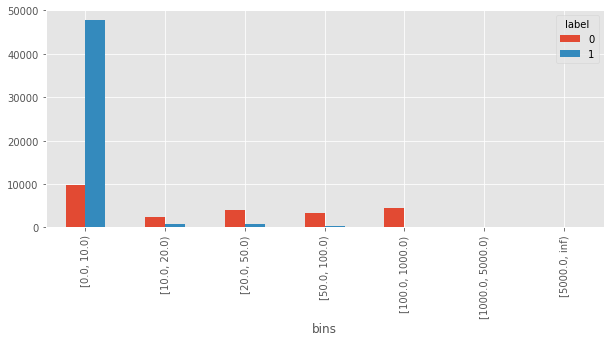

In [312]:
ax = df_1_bins.plot.bar()
plt.rcParams["figure.figsize"] = (10,4)
plt.show()

In [309]:
df_time_windows2 = df.loc[:,['count_in_recent_2week','label']]
df_time_windows2['bins'] = list(pd.cut(df_time_windows2.count_in_recent_2week, bins=bins_window, 
       right=False, labels=None, retbins=False, precision=1, include_lowest=True))
df_2_bins = df_time_windows2.groupby(['bins','label']).size().unstack().fillna(0)
df_2_bins

label,0,1
bins,,
"[0.0, 10.0)",10002.0,45755.0
"[10.0, 20.0)",2360.0,916.0
"[20.0, 50.0)",4074.0,1338.0
"[50.0, 100.0)",3345.0,1005.0
"[100.0, 1000.0)",4072.0,559.0
"[1000.0, 5000.0)",58.0,8.0
"[5000.0, inf)",2.0,0.0


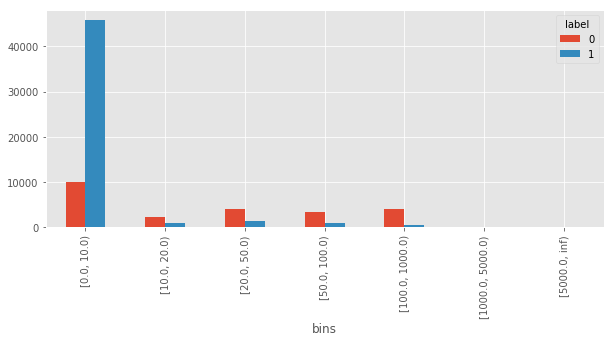

In [311]:
ax = df_2_bins.plot.bar()
plt.rcParams["figure.figsize"] = (10,4)
plt.show()

In [314]:
df_time_windows5 = df.loc[:,['count_in_recent_5week','label']]
df_time_windows5['bins'] = list(pd.cut(df_time_windows5.count_in_recent_5week, bins=bins_window, 
       right=False, labels=None, retbins=False, precision=1, include_lowest=True))
df_5_bins = df_time_windows5.groupby(['bins','label']).size().unstack().fillna(0)
df_5_bins

label,0,1
bins,,
"[0.0, 10.0)",23913.0,36651.0
"[10.0, 20.0)",0.0,3428.0
"[20.0, 50.0)",0.0,4031.0
"[50.0, 100.0)",0.0,2703.0
"[100.0, 1000.0)",0.0,2746.0
"[1000.0, 5000.0)",0.0,22.0


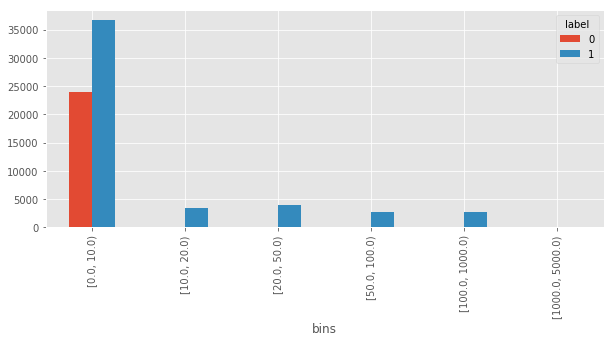

In [315]:
ax = df_5_bins.plot.bar()
plt.rcParams["figure.figsize"] = (10,4)
plt.show()

In [325]:
df_time_windows['label']=df.label
df_time_windows.loc[df_time_windows.label == 0].describe()

,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label
count,23913.000000,23913.000000,23913.000000,23913.000000,23913.0,23913.0
mean,64.170326,61.706436,75.601807,38.340317,0.0,0.0
std,143.347179,151.041857,178.116116,83.309591,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,1.000000,1.000000,2.000000,1.000000,0.0,0.0
50%,18.000000,17.000000,24.000000,12.000000,0.0,0.0
75%,72.000000,67.000000,83.000000,42.000000,0.0,0.0
max,8310.000000,10611.000000,9651.000000,2699.000000,0.0,0.0


In [326]:
df_time_windows.loc[df_time_windows.label == 1].describe()

,count_in_recent_1week,count_in_recent_2week,count_in_recent_3week,count_in_recent_4week,count_in_recent_5week,label
count,49581.000000,49581.000000,49581.000000,49581.000000,49581.000000,49581.0
mean,1.999758,5.352252,11.695952,26.058087,20.584821,1.0
std,17.976326,36.359601,54.917524,68.794955,69.369654,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,9.000000,0.000000,1.0
75%,0.000000,0.000000,0.000000,25.000000,11.000000,1.0
max,956.000000,3299.000000,3410.000000,5300.000000,3734.000000,1.0


### Save df

In [328]:
filename_pickle = '/Users/Xiaoxi/Desktop/BitTiger/Capstone/data/output/modified_features_and_label.pkl'
df.to_pickle(filename_pickle)

In [330]:
df.shape

(73494, 19)

In [331]:
# test df is saved successfully
test_df = pd.read_pickle(filename_pickle)
test_df.shape

(73494, 19)